# Product Invoice Classification

* Inv_ID (Invoice ID) : Unique number representing Invoice created by supplier/vendor

* Vendor Code (Vendor ID) : Unique number representing Vendor/Seller in the procurement system

* GL_Code: Account’s Reference ID

* Inv_Amt : Invoice Amount

* Item Description : Description of Item Purchased Example: “Corporate Services Human Resources Contingent Labor/Temp Labor Contingent Labor/Temp Labor”

* Product Category : Category of Product for which Invoice is raised A pseudo product category is represented in the dataset as CLASS-???, where ? is a digit.* 

## Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import re
import itertools
import collections

## Data

In [5]:
train_data = pd.read_csv('Train.csv')
test_data = pd.read_csv('Test.csv')
sample_submission_data = pd.read_csv('sample_submission.csv')

## Exploration

In [6]:
train_data.head()

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description,Product_Category
0,15001,VENDOR-1676,GL-6100410,83.24,Artworking/Typesetting Production Jun 2009 Cha...,CLASS-1963
1,15002,VENDOR-1883,GL-2182000,51.18,Auto Leasing Corporate Services Corning Inc /N...,CLASS-1250
2,15004,VENDOR-1999,GL-6050100,79.02,Store Management Lease/Rent Deltona Corp Real ...,CLASS-1274
3,15005,VENDOR-1771,GL-6101400,48.50,Store Construction General Requirements Coloni...,CLASS-1522
4,15006,VENDOR-1331,GL-2182000,63.35,Jul 2015 Aydin Corp Contingent Labor/Temp Labo...,CLASS-1376


In [7]:
test_data.head()

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description
0,15003,VENDOR-2513,GL-6050310,56.13,Travel and Entertainment Miscellaneous Company...
1,15008,VENDOR-1044,GL-6101400,96.56,Final Site Clean Up Store Construction Advance...
2,15013,VENDOR-1254,GL-6101400,55.93,Arabian American Development Co Final Site Cle...
3,15019,VENDOR-1331,GL-2182000,32.62,Corporate Services Contingent Labor/Temp Labor...
4,15020,VENDOR-2513,GL-6050310,25.81,Fortune National Corp Miscellaneous Company Ca...


## Train Data EDA

In [8]:
len(train_data)

5566

In [9]:
train_data.isnull().sum()

Inv_Id              0
Vendor_Code         0
GL_Code             0
Inv_Amt             0
Item_Description    0
Product_Category    0
dtype: int64

In [10]:
tmp = train_data==0 
tmp.sum()

Inv_Id              0
Vendor_Code         0
GL_Code             0
Inv_Amt             0
Item_Description    0
Product_Category    0
dtype: int64

### The Target

In [11]:
len(train_data.Product_Category.unique())

36

In [12]:
#[True if x in test_data.Product_Category.unique() else False for x in train_data.Product_Category.unique()]

In [13]:
to_plot = train_data.groupby('Product_Category', as_index = False).agg(counts = ('Inv_Id','count')).sort_values('counts')

Text(0.5, 1.0, 'Classes')

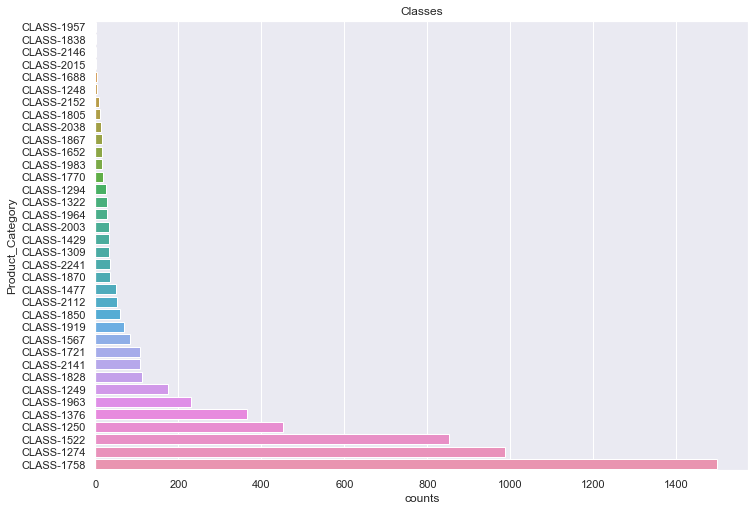

In [14]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot( data= to_plot, x="counts", y = 'Product_Category').set_title("Classes")

In [15]:
to_plot['ranks'] = range(1,len(to_plot)+1)

In [16]:
map_target = dict(to_plot[['Product_Category','ranks']].values)

In [17]:
train_data['Map_Product_Category'] = train_data.Product_Category.map(map_target)

In [18]:
train_data.head()

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description,Product_Category,Map_Product_Category
0,15001,VENDOR-1676,GL-6100410,83.24,Artworking/Typesetting Production Jun 2009 Cha...,CLASS-1963,31
1,15002,VENDOR-1883,GL-2182000,51.18,Auto Leasing Corporate Services Corning Inc /N...,CLASS-1250,33
2,15004,VENDOR-1999,GL-6050100,79.02,Store Management Lease/Rent Deltona Corp Real ...,CLASS-1274,35
3,15005,VENDOR-1771,GL-6101400,48.50,Store Construction General Requirements Coloni...,CLASS-1522,34
4,15006,VENDOR-1331,GL-2182000,63.35,Jul 2015 Aydin Corp Contingent Labor/Temp Labo...,CLASS-1376,32


### The features

In [19]:
train_data.head()

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description,Product_Category,Map_Product_Category
0,15001,VENDOR-1676,GL-6100410,83.24,Artworking/Typesetting Production Jun 2009 Cha...,CLASS-1963,31
1,15002,VENDOR-1883,GL-2182000,51.18,Auto Leasing Corporate Services Corning Inc /N...,CLASS-1250,33
2,15004,VENDOR-1999,GL-6050100,79.02,Store Management Lease/Rent Deltona Corp Real ...,CLASS-1274,35
3,15005,VENDOR-1771,GL-6101400,48.50,Store Construction General Requirements Coloni...,CLASS-1522,34
4,15006,VENDOR-1331,GL-2182000,63.35,Jul 2015 Aydin Corp Contingent Labor/Temp Labo...,CLASS-1376,32


In [20]:
len(train_data.Inv_Id.unique())

5566

In [21]:
len(train_data.Vendor_Code.unique())

1253

In [22]:
len(train_data.GL_Code.unique())

9

In [23]:
len(train_data.Item_Description.unique())

5558

Text(0.5, 1.0, 'Classes')

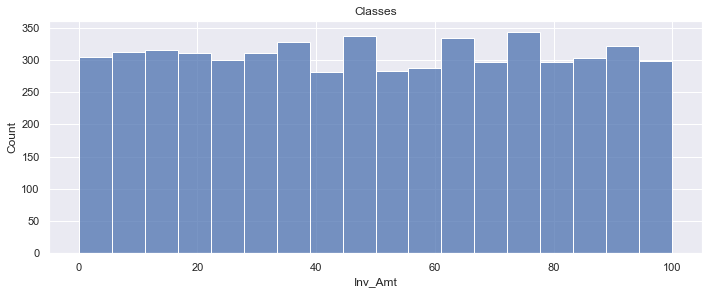

In [24]:
sns.set(rc={'figure.figsize':(11.7,4.27)})
sns.histplot( data= train_data, x="Inv_Amt").set_title("Classes")

#### Deeper analysis

<b> Vendor_Code

In [25]:
train_data[['TypeEnt','TypeEnt_number']] = train_data.Vendor_Code.str.split('-',expand=True)

In [26]:
train_data = train_data.drop(columns = 'TypeEnt')

In [27]:
len(train_data.TypeEnt_number.unique())  ## count or mean encoding

1253

In [28]:
tmp = train_data.groupby(['TypeEnt_number','Map_Product_Category'], as_index = False).agg(counts = ('Inv_Id','count'))
tmp["Rank"] = tmp.groupby(["TypeEnt_number"])["counts"].rank("dense", ascending=False)
tmp = tmp[tmp.Rank == 1]
map_rank =  dict(tmp[['TypeEnt_number','Map_Product_Category']].values)

In [29]:
train_data['ModeProductCategory_Vendor'] = train_data.TypeEnt_number.map(map_rank)

In [30]:
to_plot = train_data.groupby('ModeProductCategory_Vendor', as_index = False).agg(counts = ('Inv_Id','count')).sort_values('counts')

Text(0.5, 1.0, 'ModeProductCategory_Vendor')

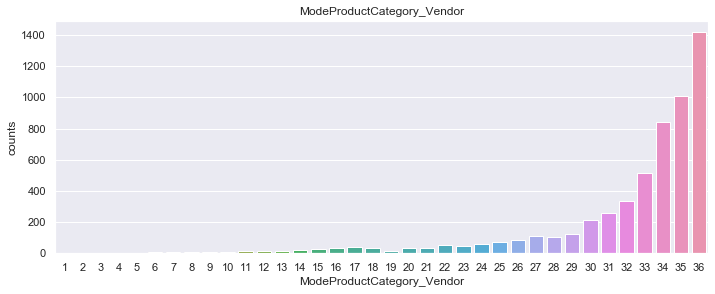

In [31]:
sns.set(rc={'figure.figsize':(11.7,4.27)})
sns.barplot( data= to_plot, y="counts", x = 'ModeProductCategory_Vendor').set_title("ModeProductCategory_Vendor")

apply custom map

<b> GCL code

In [32]:
train_data[['GCL','GCL_number']] = train_data.GL_Code.str.split('-',expand=True)

In [33]:
train_data = train_data.drop(columns = 'GCL')

In [34]:
train_data.GCL_number.unique()

array(['6100410', '2182000', '6050100', '6101400', '6050310', '6060100',
       '6100500', '6121905', '6020600'], dtype=object)

In [35]:
to_plot = train_data.groupby(['GCL_number','ModeProductCategory_Vendor'], as_index = False).agg(counts = ('Inv_Id','count')).sort_values('counts')

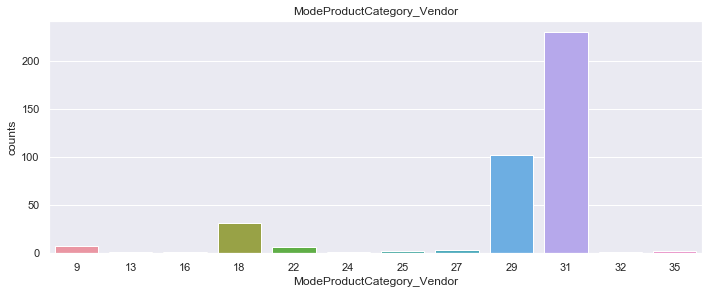

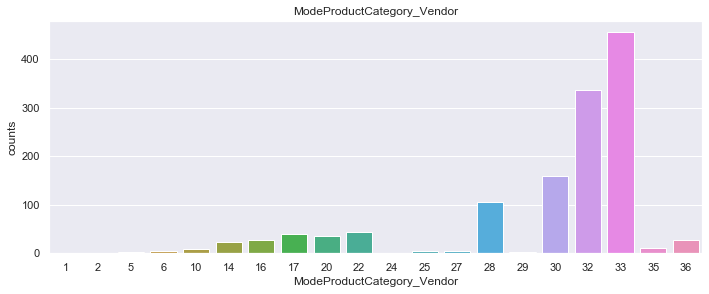

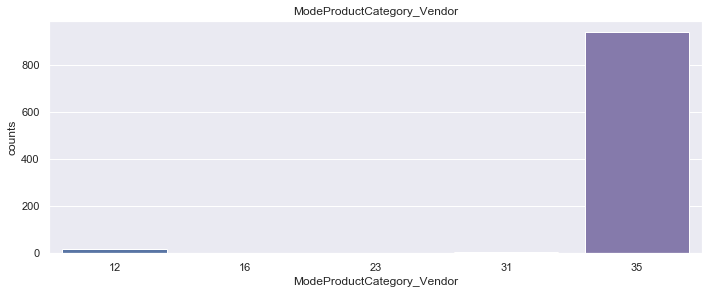

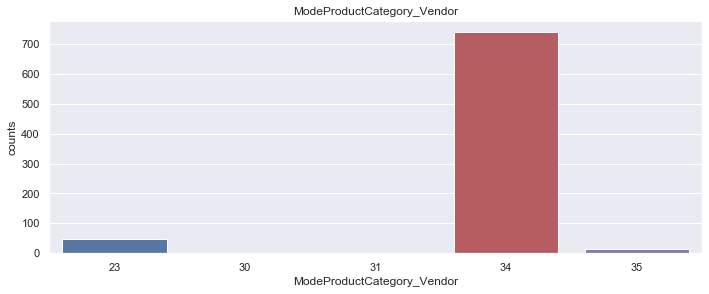

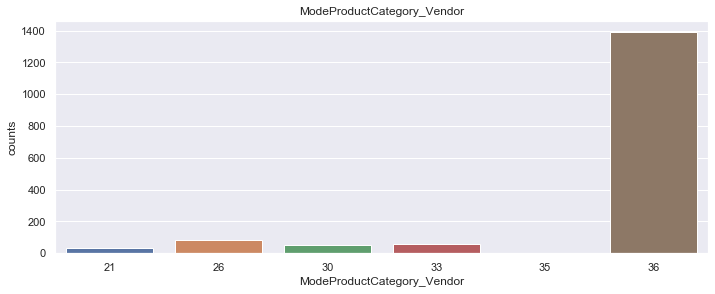

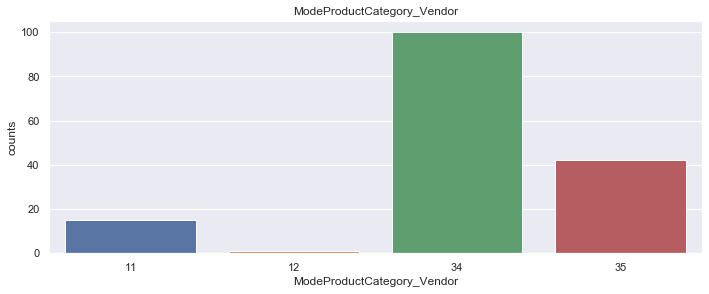

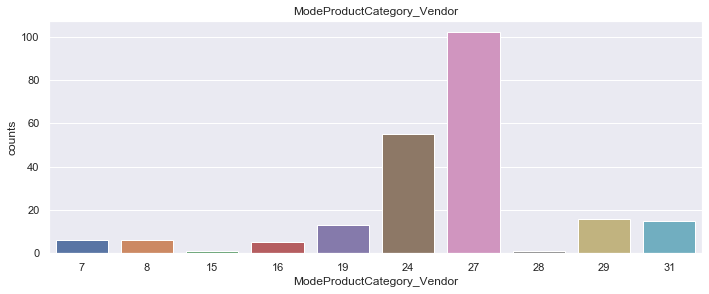

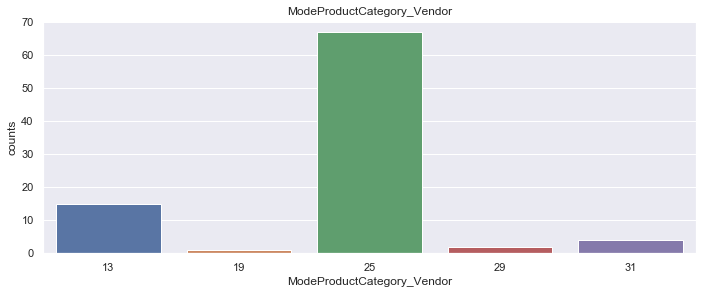

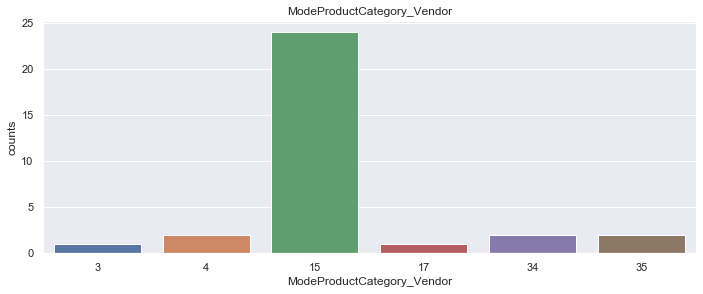

In [36]:
for i in train_data.GCL_number.unique():
    sns.set(rc={'figure.figsize':(11.7,4.27)})
    sns.barplot( data= to_plot[to_plot.GCL_number == i], y="counts", x = 'ModeProductCategory_Vendor').set_title("ModeProductCategory_Vendor")
    plt.show()

keep simple, apply ordinal encoder

<b> Inv_Amt

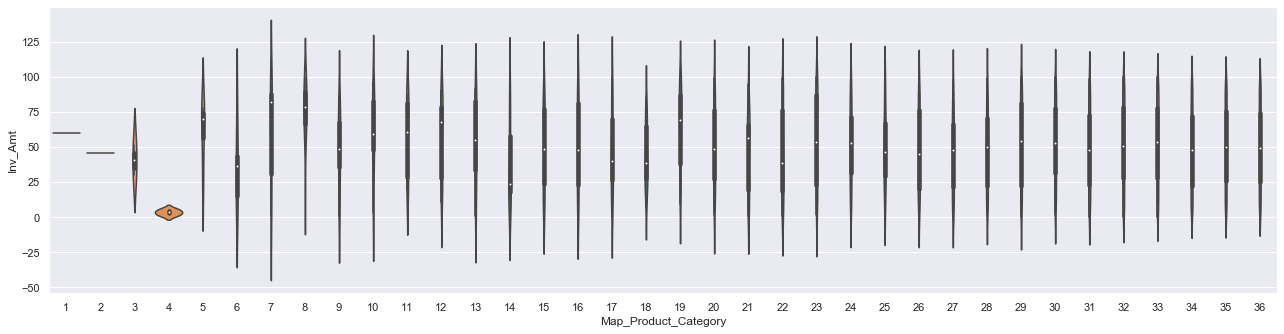

In [37]:
sns.set(rc={'figure.figsize':(22.0, 5.27)})
sns.violinplot(data=train_data, x =  'Map_Product_Category',y = 'Inv_Amt')

<b> Item description

In [38]:
def count_character(x, value):
    return x.count(value)

In [39]:
pd.set_option('display.max_colwidth', None)
tmp_analysis = train_data[['Inv_Id','Map_Product_Category','Product_Category','Item_Description']]

In [40]:
tmp_analysis['slashInDescription'] = tmp_analysis.apply(lambda x: count_character(x.Item_Description, '/'),axis = 1)

C:\Users\Miguel\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
tmp_analysis.head()

,Inv_Id,Map_Product_Category,Product_Category,Item_Description,slashInDescription
0,15001,31,CLASS-1963,Artworking/Typesetting Production Jun 2009 Champion Parts Inc SMAP Prototype and Comp Production/Packaging Design,2
1,15002,33,CLASS-1250,Auto Leasing Corporate Services Corning Inc /Ny 2013-Mar Auto Leasing and Maintenance Other Corporate Services,1
2,15004,35,CLASS-1274,Store Management Lease/Rent Deltona Corp Real Estate Base Rent Jul2018,1
3,15005,34,CLASS-1522,Store Construction General Requirements Colonial Trust Iii General Contractor Final Site Clean Up 2005-Dec,0
4,15006,32,CLASS-1376,Jul 2015 Aydin Corp Contingent Labor/Temp Labor Contingent Labor/Temp Labor Corporate Services Human Resources,2


In [42]:
tmp_analysis.groupby(['slashInDescription'], as_index = False).agg(counts = ('Inv_Id','count'))

,slashInDescription,counts
0,0,2844
1,1,1488
2,2,1075
3,3,126
4,4,29
5,5,1
6,6,3


In [43]:
to_plot = tmp_analysis.groupby(['Map_Product_Category','slashInDescription'], as_index = False).agg(counts = ('Inv_Id','count'))

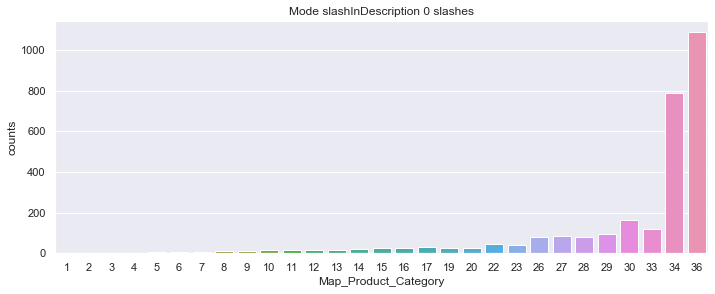

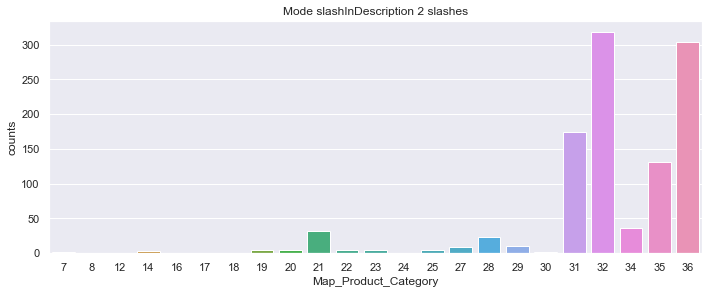

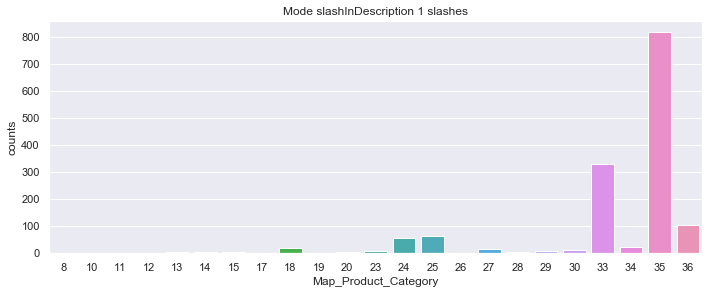

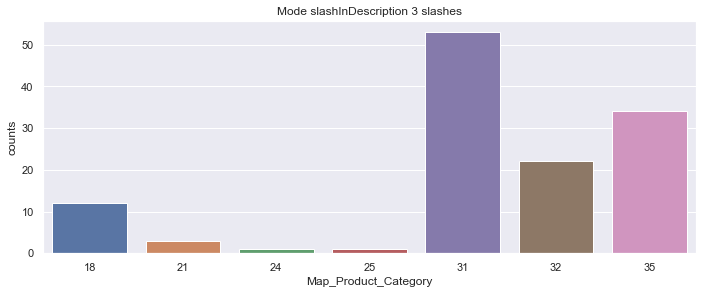

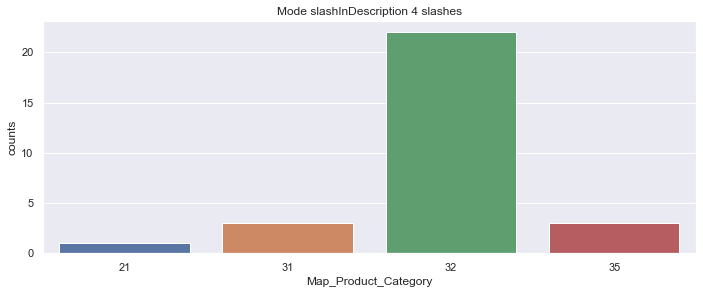

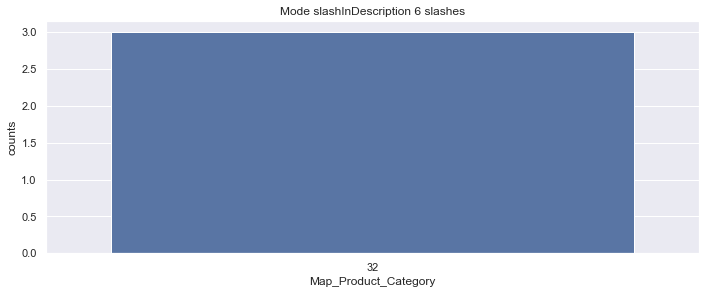

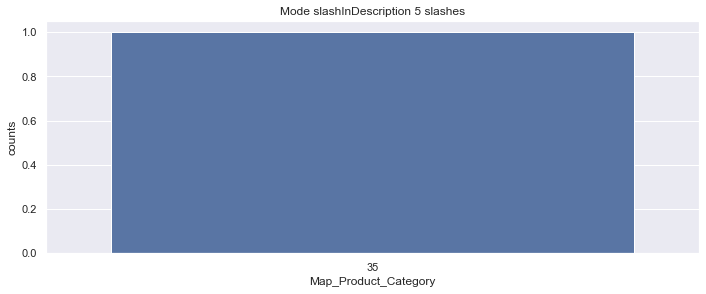

In [44]:
for i in to_plot.slashInDescription.unique():
    sns.set(rc={'figure.figsize':(11.7,4.27)})
    sns.barplot( data= to_plot[to_plot.slashInDescription == i], y="counts", x = 'Map_Product_Category').set_title(f"Mode slashInDescription {i} slashes")
    plt.show()

In [45]:
len(tmp_analysis.Item_Description.unique()), len(tmp_analysis)

(5558, 5566)

In [46]:
lists_description_split = [x.split('/') for x in tmp_analysis.Item_Description.unique()]
lists_description_split = list(itertools.chain.from_iterable(lists_description_split))
lists_description_split = list(set(lists_description_split))
lists_description_split.sort()

In [47]:
len(lists_description_split)

6051

In [48]:
lists_description_split[0:10]

['',
 '                     ',
 '                                      ',
 ' 2000-Dec  Store Construction',
 ' 2000-Jul  Miscellaneous Company Car (Field Only) Ground Transportation',
 ' 2000-Jun  Travel and Entertainment Ground Transportation Miscellaneous Company Car (Field Only) Miscellaneous Company Car (Field Only)',
 ' 2000Mar Lease',
 ' 2000Mar Media Buy - Mobile or E-Mail Direct Digital Paid Media',
 ' 2002-Aug  Lease',
 ' 2002Dec Travel and Entertainment']

In [49]:
lists_description_split[1000:1010]

['Base Rent Aug-2000 Store Management Albert Fried & Co Llc Real Estate Lease',
 'Base Rent Aug-2000 Store Management First West Virginia Bancorp Inc Real Estate Lease',
 'Base Rent Aug-2001 Store Management First Republic Corp Of America Real Estate Lease',
 'Base Rent Aug2002 Store Management Congoleum Corp Real Estate Lease',
 'Base Rent Aug2005 Store Management Bailard Biehl & Kaiser Inc                              ',
 'Base Rent Aug2005 Store Management Ddl Electronics Inc Real Estate Lease',
 'Base Rent Aug2008 Store Management American Fidelity Assurance Co                          ',
 'Base Rent Aug2010 Store Management Columbia Gas System Service Corp Real Estate Lease',
 'Base Rent Dec 2000 Store Management First Chicago Corp Real Estate Lease',
 'Base Rent Dec 2015 Store Management Cpt Holdings Inc Real Estate Lease']

In [50]:
lists_description_split[4000:4010]

['Oct2010 Alco Standard Corp Miscellaneous Company Car (Field Only) Miscellaneous Company Car (Field Only) Travel and Entertainment Ground Transportation',
 'Oct2011 Babson D L Bond Trust Contingent Labor',
 'Oct2018 American Vanguard Corp Base Rent Lease',
 'Oct2018 Fort Howard Corp Miscellaneous Company Car (Field Only) Miscellaneous Company Car (Field Only) Travel and Entertainment Ground Transportation',
 'Oh',
 'Old',
 'Old Base Rent Oct 2012 Lease',
 'Old General Contractor Final Site Clean Up May 2001',
 'Old Store Construction Store Fixtures',
 'Or']

In [51]:
lists_description_split[5000:5010]

['Sep 2009 Dollar General Corp Final Site Clean Up General Requirements Store Construction General Contractor',
 'Sep 2010 Fortune National Corp Miscellaneous Company Car (Field Only) Miscellaneous Company Car (Field Only) Travel and Entertainment Ground Transportation',
 'Sep 2011 Allegheny Energy Inc Base Rent Lease',
 'Sep 2013 Aquila Distributors Inc                                 ',
 'Sep 2014 Alabama Power Co Freight Forwarders Services Other Transportation Services Supply Chain Logistics',
 'Sep 2014 Dravo Corp Final Site Clean Up General Requirements Store Construction General Contractor',
 'Sep-2001 Fortune National Corp Miscellaneous Company Car (Field Only) Miscellaneous Company Car (Field Only) Travel and Entertainment Ground Transportation',
 'Sep-2013 Chyron Corp Miscellaneous Company Car (Field Only) Miscellaneous Company Car (Field Only) Travel and Entertainment Ground Transportation',
 'Sep-2013 Gordon Haskett & Co                                     ',
 'Sep-2014 Dex

extract the dates using reg ex

In [52]:
month_3chr = '|'.join(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] )

In [53]:
month_rx = f'({month_3chr})'
year_rx = '\d{4}'

In [54]:
regexs_dates = [f'{month_rx}{year_rx}',f'{month_rx}-{year_rx}',f'{month_rx} {year_rx}',
        f'{year_rx}{month_rx}',f'{year_rx}-{month_rx}',f'{year_rx} {month_rx}',]
regexs_dates =  '|'.join(regexs_dates)

In [55]:
def find_patter(text,regex):
    x = re.search(regex, text, re.IGNORECASE)
    return x.group(0) if x else None

In [56]:
dates = [find_patter(text, regexs_dates) for text in lists_description_split]
dates = list(set(dates))
dates.remove(None)

In [57]:
len(dates)

1189

some test

In [58]:
tmp = [text if find_patter(text, '|'.join(dates) ) is None else None  for text in lists_description_split]
tmp = [x for x in tmp if x is not None]

In [59]:
len(tmp)

495

In [60]:
tmp[0:10]

['',
 '                     ',
 '                                      ',
 ' Base Rent Lease',
 " Commercial Insurance Workmen's Insurance",
 ' Contingent Labor',
 ' Corporate Services Building and Property Insurance',
 ' Corporate Services Contingent Labor',
 ' Digital Display Digital',
 ' Digital Paid Media Media Buy - Mobile or E-Mail Direct']

converting date to naything to YYYYY-MM

In [61]:
def get_date(text, regx1, regx2):
    x = re.search(regx1, text, re.IGNORECASE)
    y = re.search(regx2, text, re.IGNORECASE)
    x = x.group(0) if x else None
    y = y.group(0) if x else None
    return f'{x}-{y}' 

In [62]:
dates_format = [ get_date(datex, year_rx, month_rx) for datex in dates ]

In [63]:
i= 150
a, b = i,i+10 
for date, datex in zip(dates[a: b], dates_format[a: b]):
    print (date, datex)

2009-Jun 2009-Jun
Nov-2005 2005-Nov
2011-Jan 2011-Jan
Jun2008 2008-Jun
2007-Jun 2007-Jun
Nov-2013 2013-Nov
Jan-2018 2018-Jan
2002Aug 2002-Aug
2014Dec 2014-Dec
2006-May 2006-May


### further in description

In [64]:
tmp_analysis['Item_Description'] = tmp_analysis['Item_Description'].str.split('/')
tmp_analysis.head()

C:\Users\Miguel\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Inv_Id,Map_Product_Category,Product_Category,Item_Description,slashInDescription
0,15001,31,CLASS-1963,"[Artworking, Typesetting Production Jun 2009 Champion Parts Inc SMAP Prototype and Comp Production, Packaging Design]",2
1,15002,33,CLASS-1250,"[Auto Leasing Corporate Services Corning Inc , Ny 2013-Mar Auto Leasing and Maintenance Other Corporate Services]",1
2,15004,35,CLASS-1274,"[Store Management Lease, Rent Deltona Corp Real Estate Base Rent Jul2018]",1
3,15005,34,CLASS-1522,[Store Construction General Requirements Colonial Trust Iii General Contractor Final Site Clean Up 2005-Dec ],0
4,15006,32,CLASS-1376,"[Jul 2015 Aydin Corp Contingent Labor, Temp Labor Contingent Labor, Temp Labor Corporate Services Human Resources]",2


In [65]:
tmp_xplode = tmp_analysis.explode('Item_Description').copy()
tmp_xplode['len_Item_Description'] = tmp_xplode['Item_Description'].str.len()

In [66]:
len(tmp_xplode)

9721

In [67]:
tmp_xplode.len_Item_Description.describe()

count    9721.000000
mean       67.938381
std        49.971195
min         0.000000
25%        27.000000
50%        56.000000
75%       107.000000
max       191.000000
Name: len_Item_Description, dtype: float64

In [68]:
tmp_plot = tmp_xplode[tmp_xplode.len_Item_Description < 20].copy()

In [69]:
plot_mode = tmp_plot.groupby(['Item_Description','Map_Product_Category'], as_index = False).agg(counts = ('Inv_Id', 'count'))
plot_mode['Rank'] = plot_mode.groupby('Item_Description')['counts'].rank(ascending=True,method='first').astype(int)
plot_mode = plot_mode[plot_mode.Rank == 1.0]

In [70]:
plot_mode.head()

,Item_Description,Map_Product_Category,counts,Rank
0,,13,1,1
14,2000Mar Lease,35,1,1
15,2002-Aug Lease,35,1,1
16,2004-Nov Lease,35,1,1
17,2007-Mar SMAP,19,1,1


In [71]:
uniquedescr = list(tmp_xplode.Item_Description.unique())

In [72]:
len(uniquedescr)

6051

In [73]:
uniquedescr[0:10]

['Artworking',
 'Typesetting Production Jun 2009 Champion Parts Inc SMAP Prototype and Comp Production',
 'Packaging Design',
 'Auto Leasing Corporate Services Corning Inc ',
 'Ny 2013-Mar  Auto Leasing and Maintenance Other Corporate Services',
 'Store Management Lease',
 'Rent Deltona Corp Real Estate Base Rent Jul2018',
 'Store Construction General Requirements Colonial Trust Iii General Contractor Final Site Clean Up 2005-Dec ',
 'Jul 2015 Aydin Corp Contingent Labor',
 'Temp Labor Contingent Labor']

In [74]:
def window_token_unique(list_text, window):
    unique_words = list()

    for text in list_text:
        token_list = text.split(' ')
        limit = len(token_list)
        result = [token_list[i:i+window] for i in range(limit)]
        result = result[0:-(window-1)] if window > 1 else result
        token_list = [' '.join(list_token) for list_token in result  ]
        for token in token_list:
            if token not in unique_words:
                unique_words.append(token)
    return unique_words

In [75]:
tmp = window_token_unique(list_text = uniquedescr, window = 3)

In [76]:
len(tmp)

18662

In [77]:
output =  dict()
for x in tmp:
    i = 0
    for text in uniquedescr:
        counts = text.count(x)
        i = i + counts
    output[x] = i

In [78]:
dict_data = {'token':list(), 'uniqueCount':list()}
for key in output:
    dict_data['token'].append(key)
    dict_data['uniqueCount'].append(output[key])

pdOutput = pd.DataFrame(dict_data)

In [79]:
pdOutput[pdOutput.uniqueCount > 20].sort_values('uniqueCount',ascending = False).head()

,token,uniqueCount
92,,5553
67,Car (Field Only),2681
66,Company Car (Field,2681
65,Miscellaneous Company Car,2681
343,Miscellaneous Company,2327


In [80]:
captures = ['Travel and Entertainment','Company Car','Corporate Services', 'Auto Leasing','General Contractor','Store Construction',
           'Ground Transportation','Base Rent','Final Site','Store Management','Site Clean Up', 'General Requirements', 'Real Estate','Media Buy',
           'Trade Show','Contingent Labor','Repair and Maintenance','Agency Fees','Human Resources','Manufacturing','Fortune National','Events and Promotions',
           'Brother Industries','Fort Howard','Laboratories Inc Stockholders','Akzo Nobel','Artists & Models','National Advertising','Transportation Services',
           'Miscellaneous','Mexico Power','& Paper Co','Cooper Laboratories Inc','Alco Standard Corp']

In [81]:
resutl_df = pdOutput[pdOutput.uniqueCount > 20]

for token in captures:

    resutl_df = resutl_df[~resutl_df['token'].str.contains(token)]
    resutl_df = resutl_df.sort_values('uniqueCount',ascending = False)

In [82]:
resutl_df.head()

,token,uniqueCount
92,,5553
67,Car (Field Only),2681
194,Travel and,1044
159,(Field Only) Ground,555
19,Leasing and Maintenance,500


what I can get is:
* slashes in description
* dates - done
* companies (co, inc cort)
* type of business
* key words

In [83]:
tests = ['miguel Co Ds', 'miguel Co', 'dfColombia', 'miguel Co and s', 'Coasw' 'miguel oC', 'miguel Corp', 'Corpa' , ' Corawe', 'miguel Comp']

In [84]:
myregex = r'\b Co\b| Corp\b| Inc\b| Comp\b\b'

In [85]:
def detect(regex, text):
    x = re.search(regex, text, re.IGNORECASE)
    if x:
        return True
    else:
        return False

In [86]:
len([test for test in uniquedescr if detect(regex = myregex, text = test) == True]), len(uniquedescr)

(4186, 6051)

#### Feature Gen

In [87]:
key_words = ['Travel and Entertainment','Company Car','Corporate Services', 'Auto Leasing','General Contractor','Store Construction',
           'Ground Transportation','Base Rent','Final Site','Store Management','Site Clean Up', 'General Requirements', 'Real Estate','Media Buy',
           'Trade Show','Contingent Labor','Repair and Maintenance','Agency Fees','Human Resources','Manufacturing','Fortune National','Events and Promotions',
            'Laboratories', 'Artists & Models','National Advertising','Transportation Services',
           'Miscellaneous']
key_words = '|'.join(key_words)

In [88]:
train_data[f'KeyWord'] = train_data.apply(lambda x: find_patter(x.Item_Description, key_words),axis = 1)

In [89]:
train_data['DateFound'] = train_data.apply(lambda x: find_patter(x.Item_Description, regexs_dates),axis = 1)
train_data['DateFound'] = train_data.apply(lambda x: get_date(x.DateFound, year_rx, month_rx),axis = 1)
train_data['DateFound_format'] = pd.to_datetime(train_data['DateFound'], format="%Y-%b")
train_data['YearFound'] = train_data['DateFound_format'].dt.year
train_data['MonthFound'] = train_data['DateFound_format'].dt.month

In [90]:
def get_str(text, regx1):
    x = re.search(regx1, text, re.IGNORECASE)
    x = x.group(0) if x else None
    return f'{x}' 

In [91]:
train_data['CompanyFoundType'] = train_data.apply(lambda x: get_str(x.Item_Description, myregex),axis = 1)

In [92]:
train_data[['CompanyFoundType','DateFound','KeyWord']]= train_data[['CompanyFoundType','DateFound','KeyWord']].replace({np.nan:0, None: 0})

In [93]:
train_data.head(5)

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description,Product_Category,Map_Product_Category,TypeEnt_number,ModeProductCategory_Vendor,GCL_number,KeyWord,DateFound,DateFound_format,YearFound,MonthFound,CompanyFoundType
0,15001,VENDOR-1676,GL-6100410,83.24,Artworking/Typesetting Production Jun 2009 Champion Parts Inc SMAP Prototype and Comp Production/Packaging Design,CLASS-1963,31,1676,31,6100410,0,2009-Jun,2009-06-01,2009,6,Inc
1,15002,VENDOR-1883,GL-2182000,51.18,Auto Leasing Corporate Services Corning Inc /Ny 2013-Mar Auto Leasing and Maintenance Other Corporate Services,CLASS-1250,33,1883,33,2182000,Auto Leasing,2013-Mar,2013-03-01,2013,3,Inc
2,15004,VENDOR-1999,GL-6050100,79.02,Store Management Lease/Rent Deltona Corp Real Estate Base Rent Jul2018,CLASS-1274,35,1999,35,6050100,Store Management,2018-Jul,2018-07-01,2018,7,Corp
3,15005,VENDOR-1771,GL-6101400,48.50,Store Construction General Requirements Colonial Trust Iii General Contractor Final Site Clean Up 2005-Dec,CLASS-1522,34,1771,34,6101400,Store Construction,2005-Dec,2005-12-01,2005,12,None
4,15006,VENDOR-1331,GL-2182000,63.35,Jul 2015 Aydin Corp Contingent Labor/Temp Labor Contingent Labor/Temp Labor Corporate Services Human Resources,CLASS-1376,32,1331,32,2182000,Contingent Labor,2015-Jul,2015-07-01,2015,7,Corp


In [94]:
def quick_explo(data, feature, iplots):
    to_plot = data.groupby([feature,'Map_Product_Category'], as_index = False).agg(counts = ('Inv_Id','count'))
    for i in to_plot[feature].unique()[iplots:iplots+5]:
        sns.set(rc={'figure.figsize':(11.7,4.27)})
        sns.barplot( data= to_plot[to_plot[feature] == i], y="counts", x = 'Map_Product_Category').set_title(f"Modes of: {i}")
        plt.show()

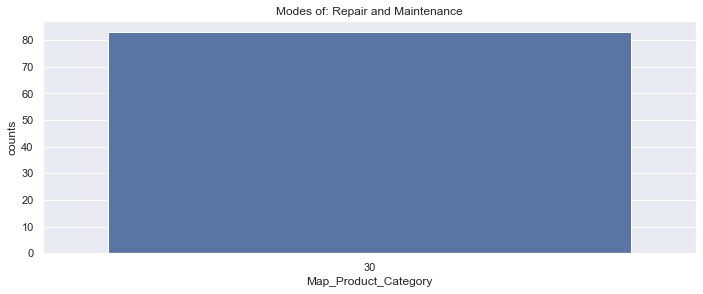

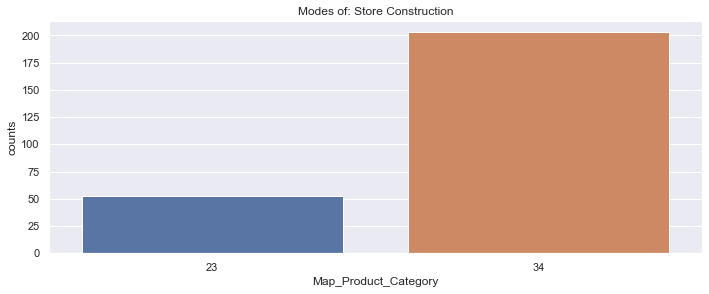

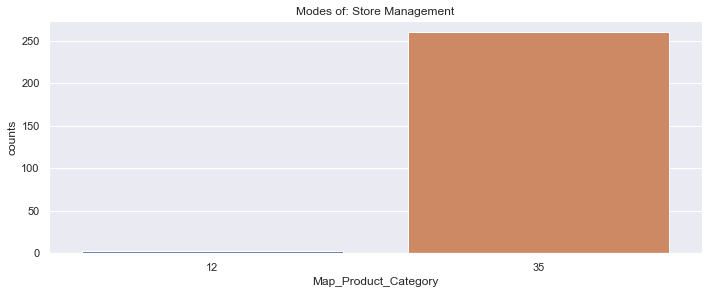

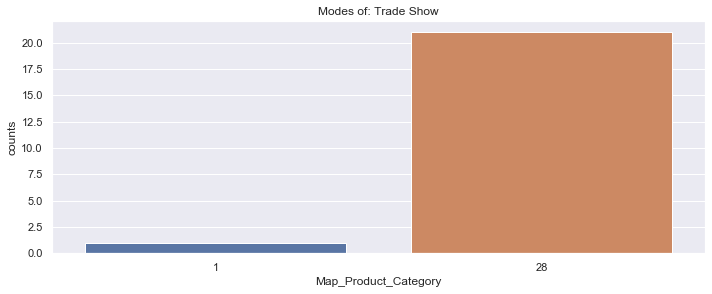

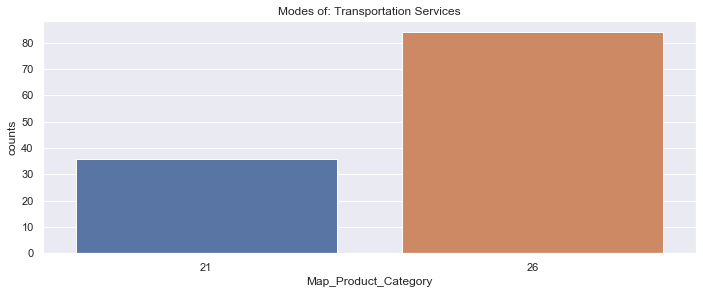

In [95]:
quick_explo(data = train_data, feature = 'KeyWord' , iplots = 20)

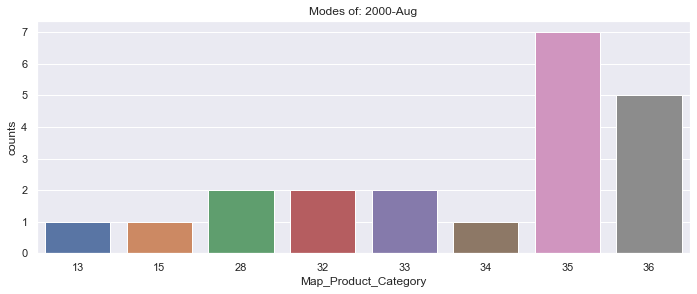

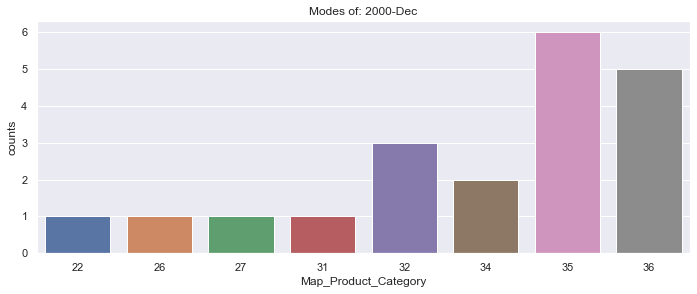

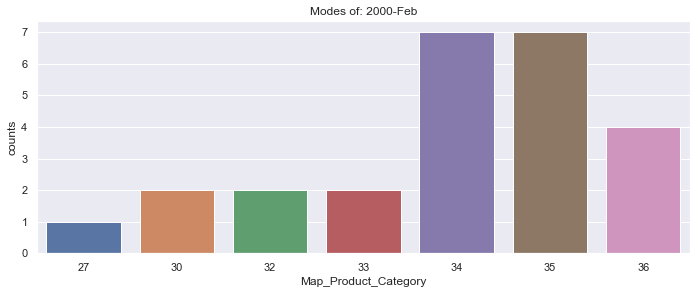

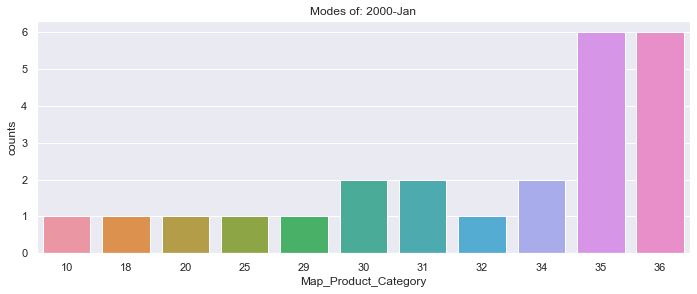

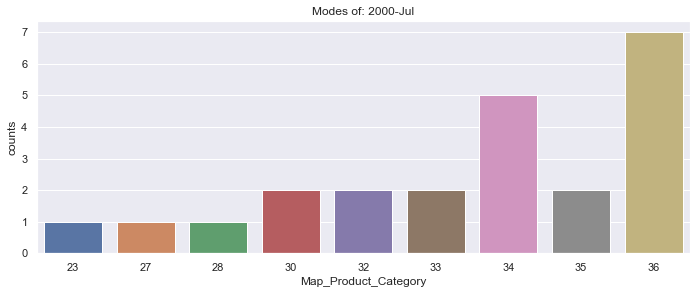

In [96]:
quick_explo(data = train_data, feature = 'DateFound' , iplots = 1)

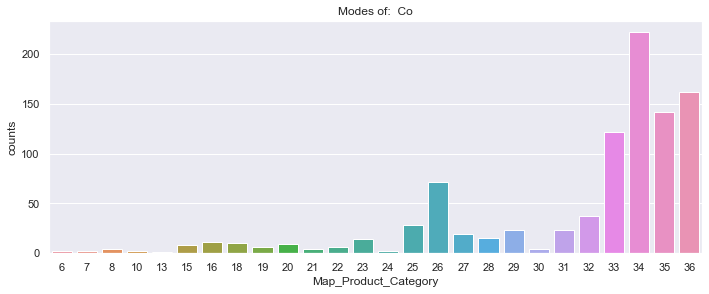

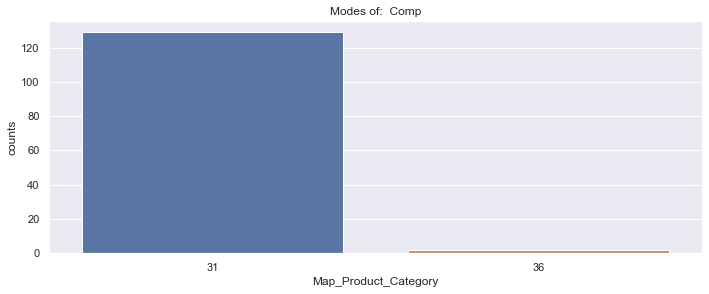

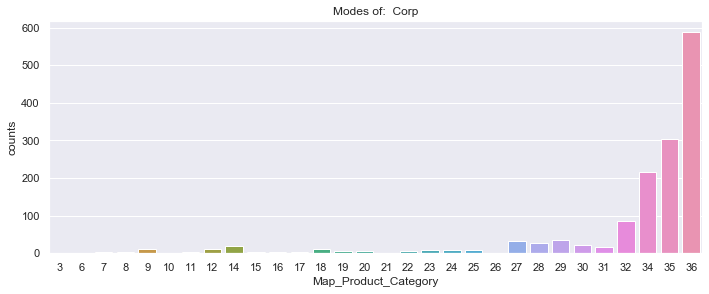

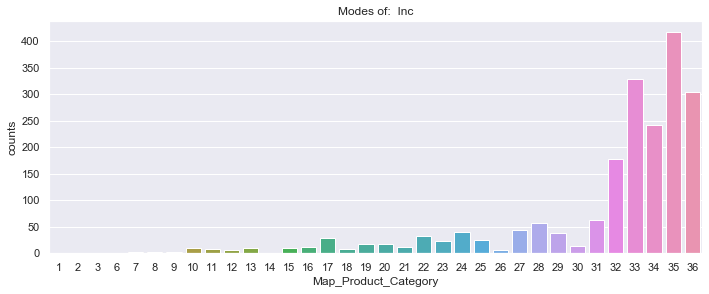

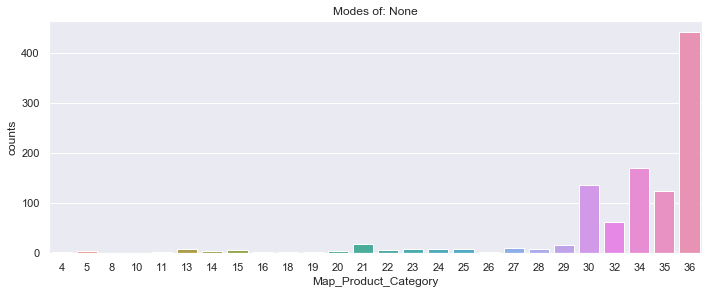

In [97]:
quick_explo(data = train_data, feature = 'CompanyFoundType' , iplots = 0)

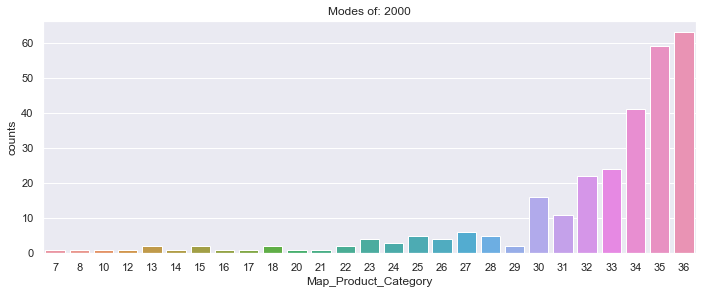

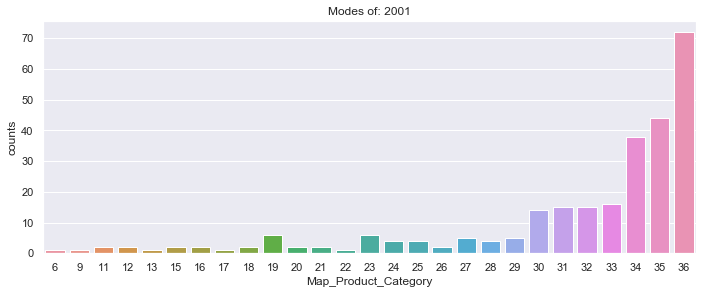

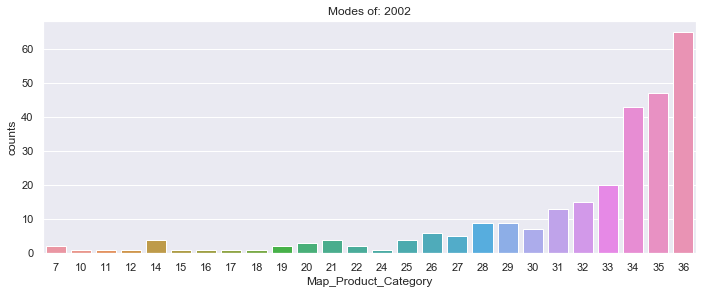

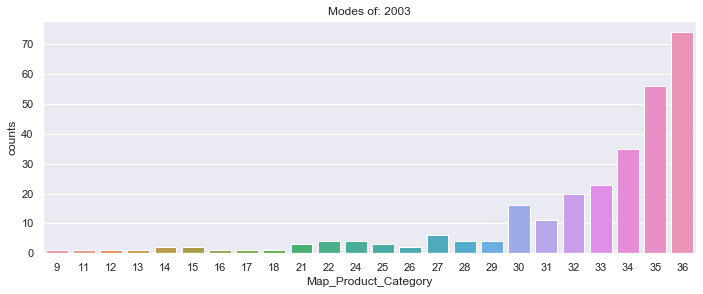

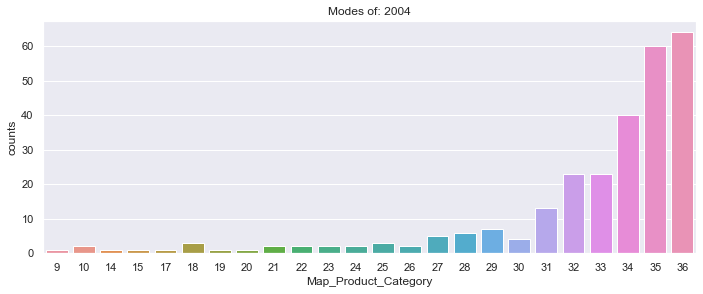

In [98]:
quick_explo(data = train_data, feature = 'YearFound' , iplots = 0)

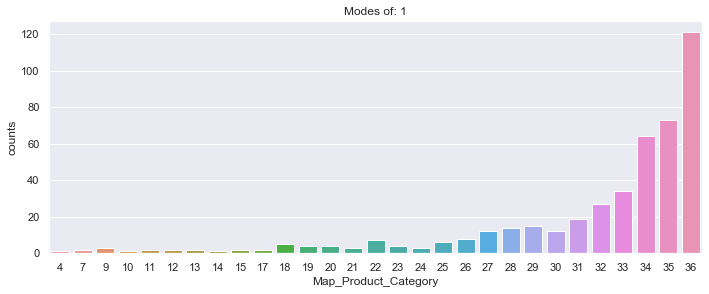

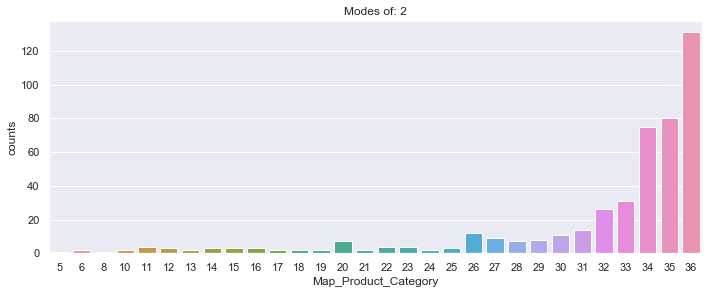

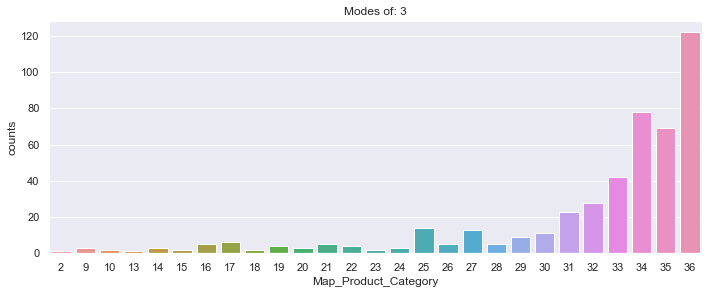

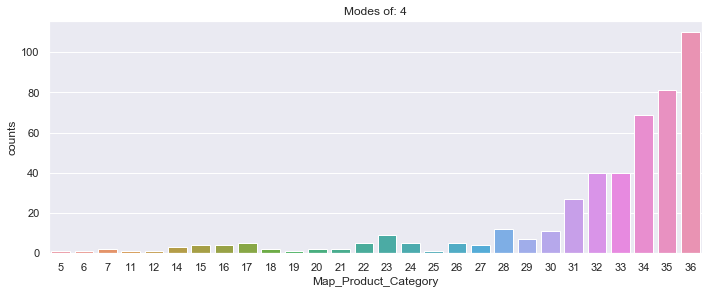

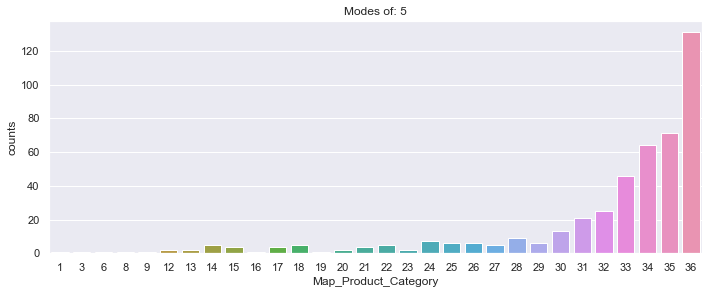

In [99]:
quick_explo(data = train_data, feature = 'MonthFound' , iplots = 0)